In [1]:
using JuMP, Gurobi, CSV, LinearAlgebra
# UW has access to a  fleet of 30 robots
num_robot = 90
# a robot can carry up to 20 pounds of food.
carry_up = 30
# one time the delivery fee is 1.99
delivery_fee = 1.99
# robots move at pedestrian speed
#robots_ speed = 4
# total carry
R1 = CSV.read("data_fourLake.csv")
(p,q) = size(R1)
time = CSV.read("dist_four.csv")
#d = 3   # number of time periods added after all the orders have been received by cafeteria (To help find optimal solution)
#cost = 1  # cost of operation for each cart in one time period
time_total = CSV.read("dist_four_final.csv")
period = [1 2 0 0 2 0 1 1 2 0 2 1 2 2 3] # number of period for making deliveries to 
R1

,Adams,Barn&ChadBradley,Column3,Cole&Sull,Dav&Sell,Dejo&Phi,Dejo&Phi_1,Kronshage
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,3,0,0,2,0,2,3
2,2,6,0,0,3,0,3,5
3,4,12,0,0,5,0,5,10
4,7,20,0,0,8,0,9,17
5,9,25,0,0,11,0,12,21
6,9,25,0,0,11,0,12,21
7,7,20,0,0,8,0,9,17
8,4,12,0,0,5,0,6,10
9,2,6,0,0,3,0,3,5


In [5]:
using JuMP, Gurobi

function delivery(lamda, d, cost)
    
m = Model(with_optimizer(Gurobi.Optimizer,OutputFlag=0))
# m = residence hall number;
# n = time period;
#lamda = 90  # the weight of satisfaction compared to the cost (higher the lamda, higher the weight of satisfaction)
@variable(m, x[1:(p+d),1:q]>=0,Int) # number of carts sent to each residential halls in each tme period
@variable(m, y[1:(p+d),1:q]>=0,Int) # number of carts back from each residential halls in each time period
@variable(m, cur[1:(p+d)]>=0, Int) # number of currently available carts
@variable(m, order[1:(p+d), 1:q] >= 0, Int) # number of orders in cumulation
# number of robots assigned to the day, and binary variable indicating when the robots can stop working 
@variable(m, robot, Int)
@variable(m, order_bin[1:(p+d)], Bin) # 0 when current period has orders left, 1 when not# 多少个cycle可以乘以cost

# all the orders must be delivered
@constraint(m, sum(x[i, j] for i =1:(p+d), j = 1:q) == sum(R1[i,j] for i = 1:p, j = 1:q))
for i = 1:(p+d)
    # the available carts in each time period <= total number of robots
    @constraint(m, cur[i] <= robot)
    #in each time period, the number of carts sent out is smaller than the currently available carts
    @constraint(m,sum(x[i,:]) <= cur[i]);
end

for j = 1:q
    #all the orders in each residential halls must be delivered.
   @constraint(m, sum(x[:,j]) == sum(R1[:,j])) 
end
for i = 1:(p+d-1)
     # when the number of orders left = 0, bin = 1; orders left = 1, bin = 0
     @constraint(m, order_bin[i]*sum(order[i,:]) == 0)
    # number of cars available in cycle (i+1) = number of available carts in cycle (i) + number of carts back in cycle (i) - 
    # number of carts sent out in cycle (i)
     @constraint(m, cur[i+1] == cur[i] + sum(y[i+1, j] for j = 1:q) - sum(x[i,j] for j = 1:q)) # set current available robots
     for j = 1:q
        #number of carts go out <=number of culmulative orders for each residential hall
        @constraint(m, x[i,j] <= order[i,j])
        if i < p # when there are still incoming orders
            #number of orders in cumulation in cycle (i+1) = number of orders in cumulation in cycle(i) 
            #+ number of orders arrive in cycle (i+1) - number of cycles sent out in cycle i.
             @constraint(m, order[i+1,j] == order[i, j] - x[i, j] + R1[i+1,j]) 
        else 
            # number of orders in cycle i+1 = number of orders in cumulation in cycle(i) - number of cycles sent out in cycle i
             @constraint(m, order[i+1,j] == order[i, j] - x[i, j])
        end
    end
end


for l = 1:q
      #set up the number of cumulative orders in the first time period
      @constraint(m, order[1,l] == R1[1,l])
end


# set up current available carts
@constraint(m, cur[1] == robot)
# constraint to make the robots be back at the right time
for i = 1:(p+d-1) 
      for j=1:q
        #set up the number of carts back from each residential hall (0)
            @constraint(m, y[1 ,j] == 0)
            if (period[j] > 0)
                  if (period[j] >= i)   
                        @constraint(m, y[i,j] == 0)   # the first several cycles are definitely 0    
                  else
                        # for the case that start getting carts back from that dorm
                        @constraint(m, y[i,j] == x[(i-period[j]),j]) # when the cart is back
                  end
            else
                  @constraint(m, y[i,j] == 0)
            end
      end
end

@objective(m, Min, sum(robot*cost*30*sum((p+d-order_bin[l]) for l = 1:(p+d)) for i = 1:(p+d)) + 
                lamda*(sum((x[i,j]*i*30 + time[j,1]) for i = 1:(p+d), j = 1:15) - sum(R1[i,j]*i*30 for i = 1:p, j = 1:q)))
optimize!(m)
value.(cur)
result = value.(x)
robot_v = value(robot)
obj = objective_value(m)
    return robot_v, obj
end

delivery (generic function with 1 method)

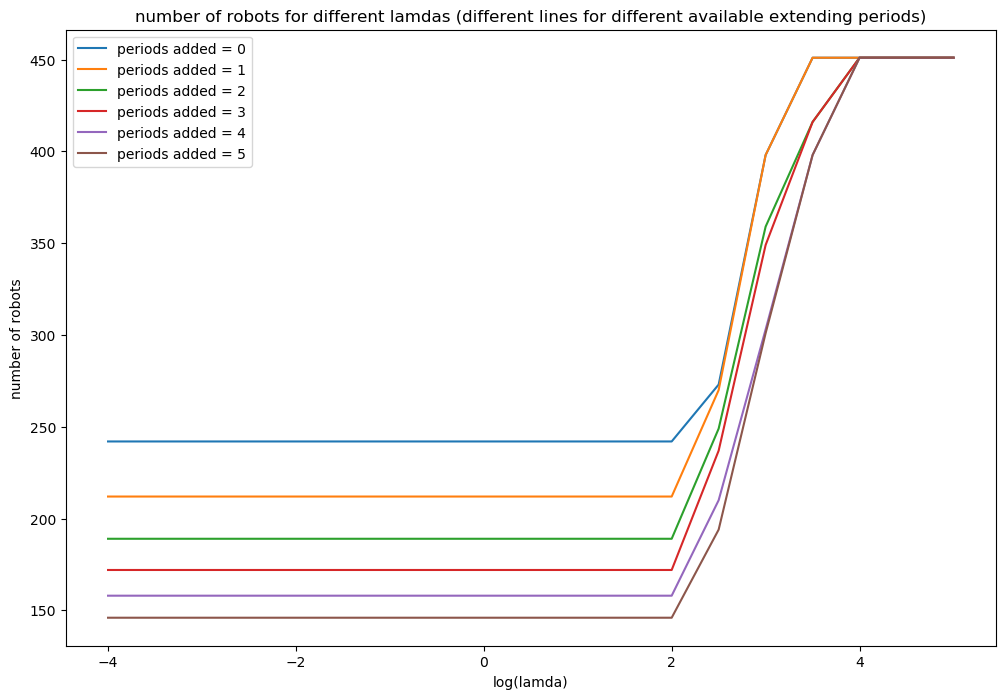

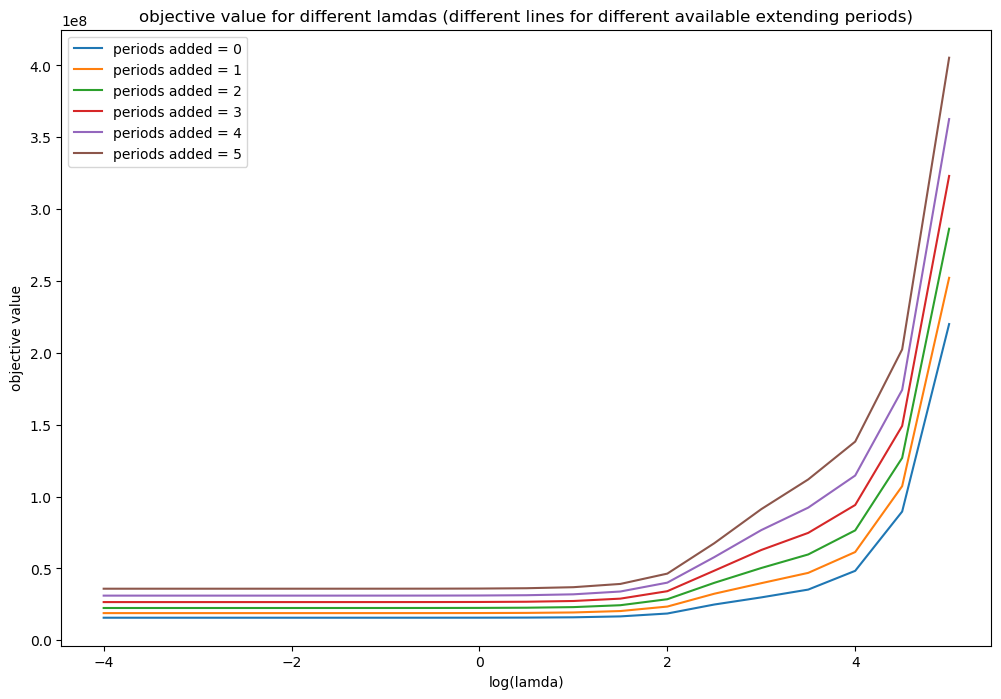

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

PyObject Text(0.5, 1, 'objective value for different lamdas (different lines for different available extending periods)')

In [42]:
using JuMP, Gurobi, PyPlot
lamda_ = [0.00001 0.0001 0.001 0.01 0.1 1 10 50 70 90 100 200 500 700 1000 10000]
lamda_log = -4:0.5:5
lamda_p = 10 .^ (lamda_log)
t = size(lamda_log)
#t = 16
d_p = [0 1 2 3 4 5]
robot_all = zeros(19, 6) # 1st dimension for changing lamda, 2nd dimension for changing cost 
obj_all = zeros(19, 6)
for i = 1:19
   for j = 1:6
        robot_all[i,j], obj_all[i,j] = delivery(lamda_p[i], d_p[j], 3)
   end
end

figure(figsize=(12,8))
for k = 1:6
    plot(lamda_log,robot_all[:,k]);
end

xlabel("log(lamda)"); ylabel("number of robots");
legend(["periods added = 0", "periods added = 1", "periods added = 2", 
        "periods added = 3", "periods added = 4", "periods added = 5"])
title("number of robots for different lamdas (different lines for different available extending periods)")

figure(figsize=(12,8))
for k = 1:6
    plot(lamda_log,obj_all[:,k]);
end

xlabel("log(lamda)"); ylabel("objective value");
legend(["periods added = 0", "periods added = 1", "periods added = 2", 
        "periods added = 3", "periods added = 4", "periods added = 5"])
title("objective value for different lamdas (different lines for different available extending periods)")